In [1]:
import torch
print(torch.__version__)
print(torch.cuda.is_available())
print(torch.version.cuda)
print('Location:', torch.__file__) # /home/emre/.local/lib/python3.7/site-packages

/home/emre/anaconda3/envs/emre_venv/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


1.12.0+cu102
True
10.2
Location: /home/emre/anaconda3/envs/emre_venv/lib/python3.9/site-packages/torch/__init__.py


In [2]:
from typing import Union, Tuple
from torch_geometric.typing import OptPairTensor, Adj, Size # Optional[Tensor], Union[Tensor, SparseTensor], Optional[Tuple[int, int]], all about data type

from torch import Tensor
from torch.nn import Linear
import torch.nn.functional as F
from torch_sparse import SparseTensor, matmul
from torch_geometric.nn.conv import MessagePassing

In [3]:
import warnings
warnings.filterwarnings("ignore")
from joblib import Parallel, delayed

from sklearn.preprocessing import StandardScaler, MinMaxScaler

import torch.nn as nn
import torch.nn.functional as F
import torch_geometric.nn as gnn
from torchsummary import summary
import torchvision
from torch_geometric.nn import MessagePassing, GCNConv
from torch_geometric.data import Dataset, Data, DataLoader
from torch_geometric.nn import global_mean_pool as gap, global_max_pool as gmp
from torch_geometric.utils import softmax

In [4]:
import pickle
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
!CUDA_LAUNCH_BLOCKING=1
torch.cuda.set_device(0)
print('Num GPU:', torch.cuda.device_count())
print('Current device:', torch.cuda.current_device())
print('Device name:', torch.cuda.get_device_name())

Num GPU: 3
Current device: 0
Device name: TITAN V


In [5]:
def load_pkl(filename):
    with open(filename, 'rb') as input:
        data = pickle.load(input)
    return data

In [6]:
[train_files, train_skels, train_labels, train_mask,
        test_files, test_skels, test_labels, test_mask] = load_pkl('../datasets/imit_ASL_10_skel.pkl')
train_skels = np.swapaxes(train_skels, 1, 3) # use 2 samples for fast implementation testing
test_skels = np.swapaxes(test_skels, 1, 3)
train_labels = np.argmax(train_labels, -1)
test_labels = np.argmax(test_labels, -1)

# print(train_vids.shape)
print(train_skels.shape)
print(train_labels.shape)
print(train_mask.shape)

(1539, 42, 3, 150)
(1539,)
(1539, 150)


In [7]:
# for simplicity merge node features and time dims
train_skels2 = train_skels.reshape(train_skels.shape[0], train_skels.shape[1],
                                  train_skels.shape[2] * train_skels.shape[3])
test_skels2 = test_skels.reshape(test_skels.shape[0], test_skels.shape[1],
                                test_skels.shape[2] * test_skels.shape[3])
print(train_skels2.shape)

(1539, 42, 450)


In [8]:
np.unique(test_labels)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [9]:
[train_images, train_labels2, train_files2,
 test_images, test_labels2, test_files2] = load_pkl('../datasets/imit_ASL_10_mDreal_224x224.pkl')
train_labels2 = np.argmax(train_labels2, -1)
test_labels2 = np.argmax(test_labels2, -1)

print(train_images.shape)
print(train_labels2.shape)
print(test_images.shape)
print(test_labels2.shape)

(1539, 3, 224, 224)
(1539,)
(385, 3, 224, 224)
(385,)


In [10]:
# make sure skel and mD files are matching
assert np.sum([1 for i in range(len(test_files)) if test_files[i] != test_files2[i]]) == 0

## Dataloader

edges: [(0, 1), (0, 5), (0, 17), (1, 2), (2, 3), (3, 4), (5, 6), (5, 9), (6, 7), (7, 8), (9, 10), (9, 13), (10, 11), (11, 12), (13, 14), (13, 17), (14, 15), (15, 16), (17, 18), (18, 19), (19, 20), (21, 22), (21, 26), (21, 38), (22, 23), (23, 24), (24, 25), (26, 27), (26, 30), (27, 28), (28, 29), (30, 31), (30, 34), (31, 32), (32, 33), (34, 35), (34, 38), (35, 36), (36, 37), (38, 39), (39, 40), (40, 41), (1, 0), (5, 0), (17, 0), (2, 1), (3, 2), (4, 3), (6, 5), (9, 5), (7, 6), (8, 7), (10, 9), (13, 9), (11, 10), (12, 11), (14, 13), (17, 13), (15, 14), (16, 15), (18, 17), (19, 18), (20, 19), (22, 21), (26, 21), (38, 21), (23, 22), (24, 23), (25, 24), (27, 26), (30, 26), (28, 27), (29, 28), (31, 30), (34, 30), (32, 31), (33, 32), (35, 34), (38, 34), (36, 35), (37, 36), (39, 38), (40, 39), (41, 40)]
second hand: 27.957340392108662
(42, 3)


<IPython.core.display.Javascript object>


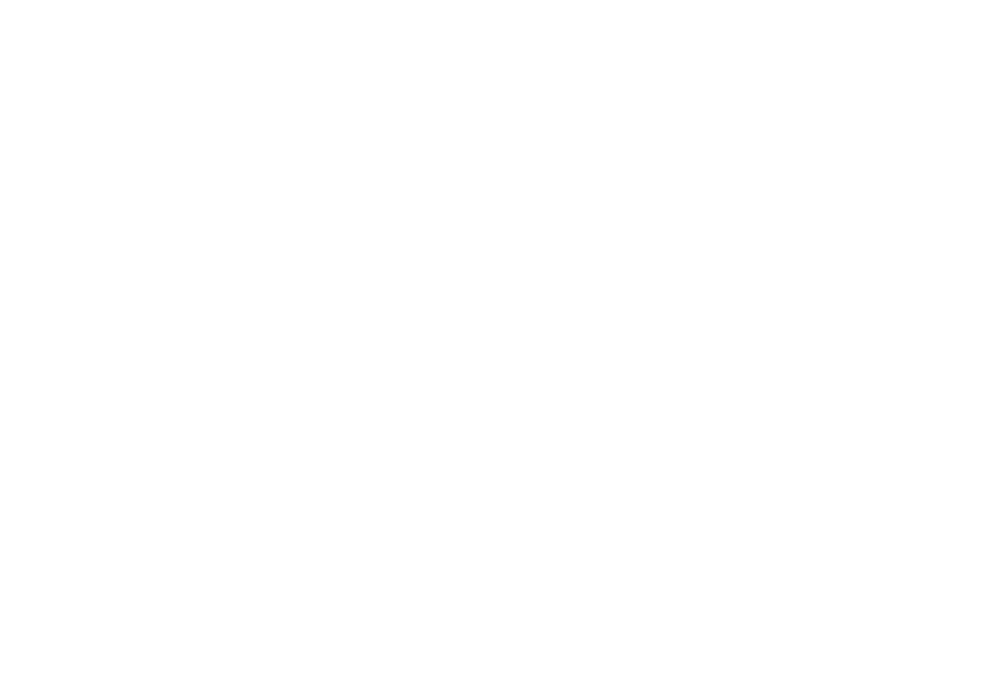

In [11]:
from mpl_toolkits import mplot3d
%matplotlib notebook
# %matplotlib inline
sample_idx = [1, 30]
edges = [(0, 1),
              (0, 5),
              (0, 17),
              (1, 2),
              (2, 3),
              (3, 4),
              (5, 6),
              (5, 9),
              (6, 7),
              (7, 8),
              (9, 10),
              (9, 13),
              (10, 11),
              (11, 12),
              (13, 14),
              (13, 17),
              (14, 15),
              (15, 16),
              (17, 18),
              (18, 19),
              (19, 20)]
second_edges = [(e[0] + 21, e[1] + 21) for e in edges]
for se in second_edges:
    edges.append(se)
for e in edges: # make edges bidirectional
    if (e[1], e[0]) not in edges:
        edges.append((e[1], e[0]))
print('edges:', edges)
# print(train_skels[sample_idx[0], :, :, sample_idx[1]])

sample = train_skels[sample_idx[0], :, :, sample_idx[1]]
print('second hand:', np.sum(sample[21:]))
print(sample.shape)
fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")
# for e in range(sample.shape[0]):
#     ax.scatter(sample[e, 0], sample[e, 1], sample[e, 2], s=5, c='r')
ax.scatter(sample[:, 0], sample[:, 1], sample[:, 2], s=25, c='r')
for e in edges:
    x_line = np.linspace(sample[e[0], 0], sample[e[1], 0], 10)
    y_line = np.linspace(sample[e[0], 1], sample[e[1], 1], 10)
    z_line = np.linspace(sample[e[0], 2], sample[e[1], 2], 10)
    ax.plot3D(x_line, y_line, z_line, c='b')

In [12]:
class CustomImageDataset(Dataset):
    def __init__(self, x, y):
        super().__init__()
        self.x = x
        self.y = y

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        temp_x = torch.tensor(self.x[idx], dtype=torch.float)
        temp_y = torch.tensor(self.y[idx], dtype=torch.long)
#         self.x = self.x[idx]
#         self.y = self.y[idx]
#         return self.x[idx], self.y[idx] 
        return temp_x, temp_y

In [13]:
class MyDataset(Dataset):
    def __init__(self, x, y):
        super().__init__()
        self.x = x
        self.y = y
    
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        
        data = Data(x=torch.tensor(self.x[idx].reshape(-1, 42).T, dtype=torch.float), y=torch.tensor(self.y[idx], dtype=torch.long),
                edge_index=torch.tensor(np.array(edges), dtype = torch.long).T)
        return data

In [14]:
class MyDataset_temporal(Dataset):
    def __init__(self, x, y):
        super().__init__()
        self.x = x
        self.y = y
    
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        
        data = Data(x=torch.tensor(self.x[idx], dtype=torch.float), y=torch.tensor(self.y[idx], dtype=torch.long),
                edge_index=torch.tensor(np.array(edges), dtype = torch.long).T)
        return data

In [15]:
class MergeDataset(Dataset):
    def __init__(self, x, y):
        super().__init__()
        self.img = x[0]
        self.graph = x[1]
        self.y = y
    
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        img = torch.tensor(self.img[idx], dtype=torch.float)
        data = Data(x=torch.tensor(self.graph[idx].reshape(-1, 42).T, dtype=torch.float), y=torch.tensor(self.y[idx], dtype=torch.long),
                edge_index=torch.tensor(np.array(edges), dtype = torch.long).T)
        return img, data

In [16]:
batch_size = 1
data_train = [torch.from_numpy(train_images), torch.from_numpy(train_skels2)]
data_test = [torch.from_numpy(test_images), torch.from_numpy(test_skels2)]

training_data = MergeDataset(data_train, torch.from_numpy(train_labels))
testing_data = MergeDataset(data_test, torch.from_numpy(test_labels))

train_loader = DataLoader(training_data, batch_size=batch_size, shuffle=False, collate_fn=lambda x: x)
test_loader = DataLoader(testing_data, batch_size=batch_size, shuffle=False, collate_fn=lambda x: x)

In [17]:
# training_features, training_labels = next(iter(train_loader))
data = next(iter(train_loader))
print(f"Feature batch shape: {data[0].size()}")
print(f"Feature batch shape: {data[1].x.size()}")
print(f"Labels batch shape: {data[1].y.size()}")

Feature batch shape: torch.Size([1, 3, 224, 224])
Feature batch shape: torch.Size([42, 450])
Labels batch shape: torch.Size([1])


## Classify skel

In [57]:
%matplotlib inline
def train( model, model_name, prog_bar = True):
    
    max_test_acc = -1
    train_accs = []
    test_accs = []
#     temp = 1
    for epoch in range(epochs):
        train_acc = []
        test_acc = []
        if prog_bar:
            pbar = tqdm(train_loader,position=0)
        else:
            pbar = train_loader
            
        # train
        for data in pbar:
            img = data[0].to(device)
            graph = data[1].to(device)
#             data = data.to(device)
            optimizer.zero_grad()
            out = model([img, graph])
            loss = criterion(out, graph.y)
            loss.backward()
            optimizer.step()
            preds = np.argmax(out.cpu().detach().numpy(), -1)
            labels = graph.y.cpu().detach().numpy()
            
            acc = np.sum(preds == labels) / len(labels) * 100
            train_acc.append(acc)
            if prog_bar:
                pbar.set_description('Train_acc: '+str(round(acc,2)))
        train_accs.append(np.mean(train_acc))
        
        # test
        all_preds = []
        test_loss = 0
        for data in test_loader:
            img = data[0].to(device)
            graph = data[1].to(device)
#             data = data.to(device)
            optimizer.zero_grad()
            out = model([img, graph])
            loss = criterion(out, graph.y)
            test_loss += loss.cpu().detach().numpy() / len(test_loader)
            preds = np.argmax(out.cpu().detach().numpy(), -1)
            labels = graph.y.cpu().detach().numpy()
            acc = np.sum(preds == labels) / len(labels) * 100
            test_acc.append(acc)
            all_preds.append(preds)
        test_accs.append(np.mean(test_acc))
        
        if np.mean(test_acc) > max_test_acc:
#             print(np.array(all_preds[0]).shape)
#             print(np.array(all_preds[1]).shape)
            best_preds = [i for a in all_preds for i in a]
            max_test_acc = np.mean(test_acc)
            torch.save(model.state_dict(), '../models/' + model_name + str(round(max_test_acc, 2)) + '.pth')
        
#         lr_scheduler.step(test_loss)
        print('Epoch: ', str(epoch+1)+'/'+str(epochs),'| Training Acc: ', round(np.mean(train_acc), 2), '| Testing Acc: ', round(np.mean(test_acc), 2))
#         train_losses.append(train_loss)
#         test_losses.append(test_loss)

        
        if not prog_bar:
            clear_output(wait=True)
            print('Epoch: ', str(epoch+1)+'/'+str(epochs),'| Training Acc: ', round(np.mean(train_acc), 2), '| Testing Acc: ', round(np.mean(test_acc), 2),
                 ', Best Testing Acc:', round(max_test_acc, 2))
            plt.plot(train_accs, label="Train Acc")
            plt.plot(test_accs, label="Validation Acc")
            plt.xlabel("# Epoch")
            plt.ylabel("Accuracy")
            plt.legend(loc='upper right')
            plt.show()
    return best_preds

## mD model

In [19]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('device:', device)

device: cuda


In [49]:
vgg16 = torchvision.models.vgg16(pretrained=True).to(device)
vgg16.fc = torch.nn.Sequential(
    nn.Linear(
        in_features=2048,
        out_features=10
    ),
    nn.Softmax()
)
vgg16.load_state_dict(torch.load('../models/model_vgg16_withTL_mDreal_imit_acc94.95.pth'))
vgg16.eval()

for param in vgg16.parameters():
    param.requires_grad = False

## skel model

In [50]:
from torch_geometric.nn.conv import SAGEConv

In [51]:
# model to make prediction for the whole graph
class SAGEConv_GNN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = SAGEConv(train_skels.shape[2]*train_skels.shape[3], 64, add_self_loops=True)
        self.conv2 = SAGEConv(64, 10, add_self_loops=True)
#         self.pool1 = gnn.GlobalAttention(torch.nn.Sequential(torch.nn.Linear(64,1)))
#         self.pool1 = gnn.global_add_pool(self.x, self.batch)
#         self.lin1 = torch.nn.Linear(len(np.unique(y_data)),1)
    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
#         print('x',x.shape)
#         print('batch',batch.shape)
        
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
#         x = self.pool1(x, batch)
        x = gmp(x, batch)
        return F.softmax(x, dim=-1)#.squeeze()

In [52]:
sage = SAGEConv_GNN().to(device)
sage.load_state_dict(torch.load('../models/model_SAGE_skel_imit_acc93.75.pth'))
sage.eval()

for param in sage.parameters():
    param.requires_grad = False

In [53]:
# out = vgg16(next(iter(test_loader))[0].to(device))
# out.shape

## Fusion

In [58]:
# model to make prediction for the whole graph
class Fusion(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.sage = sage
        self.vgg16 = vgg16
        self.lin1 = nn.Linear(20, 10)
        self.drop = nn.Dropout(0.5)
        
    def forward(self, data):
        x1, edge_index, batch = data[1].x, data[1].edge_index, data[1].batch
        x2 = data[0]
        
        x1 = self.sage(data[1])
        x2 = self.vgg16(x2)
        out = torch.cat([x1, x2[:, :10]], -1)
#         out = self.drop(out)
        out = self.lin1(out)
        
        return F.softmax(out, dim=-1)#.squeeze()

In [59]:
fusion = Fusion().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(fusion.parameters(), lr=0.001)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, verbose=True, patience=20, factor=0.5)

Epoch:  45/1000 | Training Acc:  100.0 | Testing Acc:  96.36 , Best Testing Acc: 96.62


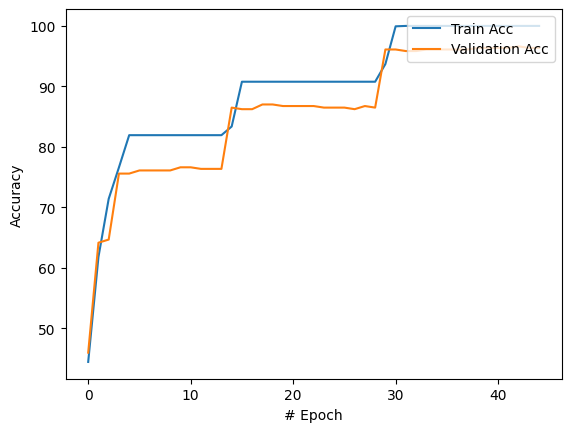

KeyboardInterrupt: 

In [60]:
model_name = 'model_fusion_mD_skel_imit_acc' # 96.62 best
epochs = 1000
best_preds = train(fusion, model_name, prog_bar = False)